In [1]:
%load_ext autoreload
%autoreload 2
import os
import torch
import argparse
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from models.shiftnet_model import ShiftNetModel
from options.train_options import TrainOptions 


# CREATE DEFAULT OPTIONS TO INITIALIZE THE SHIFTMODEL

In [2]:
dataroot = '/mnt/hdd2/AIM/DAGM/Class4_def/' # ENTER HERE THE PATH YOU WANT TO USE AS DATAROOT
options = '--dataroot {}'.format(dataroot).split(' ')

In [3]:
def get_parser(options=None):
    parser = TrainOptions()
    parser.parse(options=options)
    return parser

In [4]:
parser = get_parser(options=options)

----------------- Options ---------------
                batchSize: 1                             
                    beta1: 0.5                           
               bottleneck: 512                           
          checkpoints_dir: /mnt/hdd2/AIM/checks          
                constrain: MSE                           
           continue_train: False                         
                 dataroot: /mnt/hdd2/AIM/DAGM/Class4_def/	[default: /mnt/hdd2/AIM/DAGM/Class3]
             dataset_mode: aligned_resized               
             display_freq: 10                            
               display_id: 1                             
            display_ncols: 4                             
             display_port: 8097                          
           display_server: http://localhost              
display_single_pane_ncols: 0                             
          display_winsize: 256                           
              epoch_count: 1                       

# CREATE INNER_SHIFT_TRIPLE LAYER

In [5]:
from models.InnerShiftTriple import InnerShiftTriple

In [6]:
opt = parser.opt
#opt

In [7]:
inner_shift_triple = InnerShiftTriple(opt.threshold, opt.fixed_mask)

In [8]:
inner_shift_triple.cuda()

InnerShiftTriple(threshold: 0.3125 ,triple_weight 1)

# EVALUE SPEED FORWARD

### THE SIZE OF THE INPUT TENSOR IS (BATCH_SIZE, 256 * 2 (former | latter), 32, 32). LET CREATE A RANDOM TENSORS AND EVALUTE ITS FORWARD FIRST

In [9]:
import numpy as np
torch.cuda.is_available()

True

In [10]:
x_np = np.random.normal(0, 1, (1, 512, 32, 32))

In [11]:
x_tr = torch.FloatTensor(x_np)

### NOW WE NEED TO SET UP THE MASK

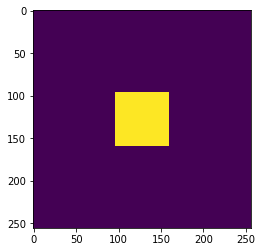

In [12]:
c, h, w = (1, 256, 256)
hh = h//2
wh = w//2
hm_size = 32
mask = np.zeros((1, c, h, w))
mask[..., hh - hm_size:hh + hm_size, wh - hm_size:wh + hm_size] = 1
mask_global=torch.ByteTensor(mask).cuda()#.cpu()
plt.imshow(np.squeeze(mask))

In [16]:
inner_shift_triple.set_mask(mask_global=mask_global, threshold=opt.threshold, layer_to_last=3)

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:1', dtype=torch.uint8)

In [17]:
x_np = np.random.normal(0, 1, (1, 512, 32, 32))

In [18]:
%time output = inner_shift_triple.forward(x_tr.cuda())

patches_part torch.Size([960, 256, 1, 1])
target_patches torch.Size([960, 256, 1, 1])
target_patches torch.Size([1024, 256, 1, 1])
torch.Size([1, 32, 32])
tensor([697,  38,   4,  ..., 115, 526, 614], device='cuda:1')
CPU times: user 580 ms, sys: 36 ms, total: 616 ms
Wall time: 613 ms


In [849]:
output.shape

torch.Size([1, 768, 32, 32])

In [850]:
# It is not as bad as what I was thinking

In [19]:
from util import util
import torch.nn.functional as F

In [20]:
def create_random_mask(opt):
    gMask_opts = {}
    mask_global = torch.ByteTensor(1, 1, \
                                 opt.fineSize, opt.fineSize)

        # Here we need to set an artificial mask_global(not to make it broken, so center hole is ok.)
    mask_global.zero_()
    mask_global[:, :, int(opt.fineSize/4) + opt.overlap : int(opt.fineSize/2) + int(opt.fineSize/4) - opt.overlap,\
                                int(opt.fineSize/4) + opt.overlap: int(opt.fineSize/2) + int(opt.fineSize/4) - opt.overlap] = 1  
    
    res = 0.06 # the lower it is, the more continuous the output will be. 0.01 is too small and 0.1 is too large
    density = 0.25
    MAX_SIZE = 300
    maxPartition = 30
    low_pattern = torch.rand(1, 1, int(res*MAX_SIZE), int(res*MAX_SIZE)).mul(255)
    pattern = F.upsample(low_pattern, (MAX_SIZE, MAX_SIZE), mode='bilinear').data
    low_pattern = None
    pattern.div_(255)
    pattern = torch.lt(pattern,density).byte()  # 25% 1s and 75% 0s
    pattern = torch.squeeze(pattern).byte()
    gMask_opts['pattern'] = pattern
    gMask_opts['MAX_SIZE'] = MAX_SIZE
    gMask_opts['fineSize'] = opt.fineSize
    gMask_opts['maxPartition'] = maxPartition
    gMask_opts['mask_global'] = mask_global
    mask_global = util.create_gMask(gMask_opts) # create an initial random mask.   
    return mask_global

In [21]:
%time mask_global = create_random_mask(opt)

CPU times: user 308 ms, sys: 4 ms, total: 312 ms
Wall time: 38.3 ms


/home/tchaton/virtualenvs/labelbox/lib/python3.6/site-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/home/tchaton/virtualenvs/labelbox/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [22]:
mask_global.shape

torch.Size([1, 1, 256, 256])

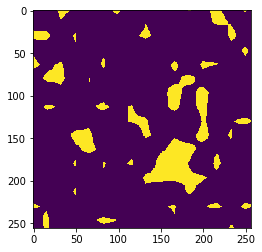

In [23]:
plt.imshow(np.squeeze(mask_global))

In [24]:
mask_global

tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]], dtype=torch.uint8)

In [25]:
inner_shift_triple.set_mask(mask_global=mask_global, threshold=opt.threshold, layer_to_last=3)

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)

In [39]:
%timeit output = inner_shift_triple.forward(x_tr.cuda())

582 ms ± 38.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# THE ENTIRE PROCESS IS PRETTY FAST, THE ISSUE WAS COMING FROM THE MASK GENERATOR

# IMPLEMENT AN ACCELERATE MODULE

In [27]:
opt = parser.opt
opt.shift_sz = 1

In [30]:
from models.accelerated_InnerShiftTriple import AcceleratedInnerShiftTriple
modified_inner_shift_triple = AcceleratedInnerShiftTriple(opt.threshold, opt.fixed_mask)

In [31]:
modified_inner_shift_triple.cuda()

AcceleratedInnerShiftTriple(threshold: 0.3125 ,triple_weight 1)

In [32]:
modified_inner_shift_triple.set_mask(mask_global=mask_global, threshold=opt.threshold, layer_to_last=3)

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)

In [33]:
%timeit output = modified_inner_shift_triple(x_tr.cuda())

155 ms ± 22.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
print('THE SPEED UP IS {} FOLD'.format(582/155))

THE SPEED UP IS 3.7548387096774194 FOLD
